1/1 [==============================] - 1s 706ms/step
RMSE: 0.3849, MSE: 0.1482, MAE: 0.2306, MAPE: 0.29%


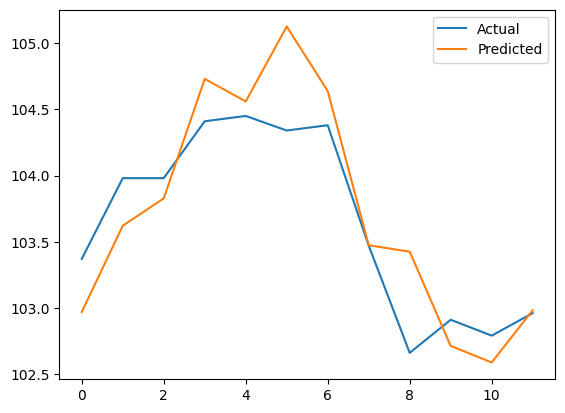

In [77]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, median_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam

class LSTMForecaster:
    def __init__(self, data_path, target_col, lags=list(range(1,13)), timesteps=3):
        self.data_path = data_path
        self.target_col = target_col
        self.lags = lags
        self.timesteps = timesteps
        self.df = None
        self.scaler = StandardScaler()

    def load_data(self):
        self.df = pd.read_csv(self.data_path, parse_dates=['time'], index_col='time')
        self.df[self.target_col] = self.scaler.fit_transform(self.df[[self.target_col]])
        for lag in self.lags:
            self.df[f'lag_{lag}'] = self.df[self.target_col].shift(lag)
        self.df = self.df.dropna()

    def prepare_data(self, test_size=12):
        features = self.df[[f'lag_{lag}' for lag in self.lags]].values
        target = self.df[self.target_col].values
        X, y = [], []
        for i in range(len(features) - self.timesteps):
            X.append(features[i:i + self.timesteps])
            y.append(target[i + self.timesteps])
        X, y = np.array(X), np.array(y)
        return X[:-test_size], X[-test_size:], y[:-test_size], y[-test_size:]

    def build_model(self, input_shape):
        model = Sequential([
            LSTM(64, input_shape=input_shape),
            Dense(1)
        ])
        model.compile(optimizer=Adam(learning_rate=0.01), loss='mse')
        return model

    def run(self, test_size=12):
        self.load_data()
        X_train, X_test, y_train, y_test = self.prepare_data(test_size)
        model = self.build_model((X_train.shape[1], X_train.shape[2]))
        model.fit(X_train, y_train, epochs=50, batch_size=16, verbose=0)
        predictions = model.predict(X_test).flatten()
        predictions = self.scaler.inverse_transform(predictions.reshape(-1, 1)).flatten()
        y_test = self.scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
        mse = mean_squared_error(y_test, predictions)
        rmse = np.sqrt(mean_squared_error(y_test, predictions))
        mae = median_absolute_error(y_test, predictions)
        mape = mean_absolute_percentage_error(y_test, predictions) * 100
        print(f"RMSE: {rmse:.4f}, MSE: {mse:.4f}, MAE: {mae:.4f}, MAPE: {mape:.2f}%")
        plt.plot(y_test, label='Actual')
        plt.plot(predictions, label='Predicted')
        plt.legend()
        plt.show()

# Sử dụng
forecaster = LSTMForecaster(data_path="data/analyzed_time_series.csv", target_col='cpi_yoy')
forecaster.run()


1/1 [==============================] - 1s 769ms/step
RMSE: 0.3588, MSE: 0.1287, MAE: 0.3494, MAPE: 0.31%


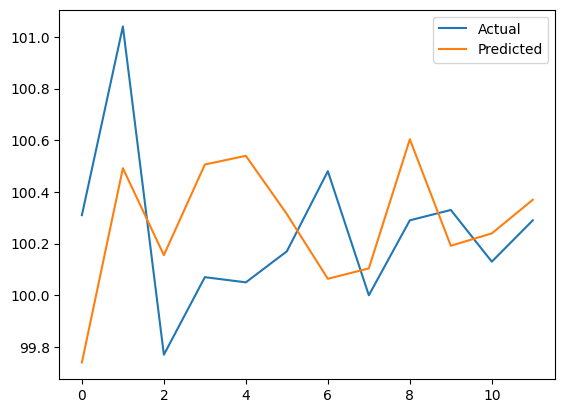

In [78]:
# Sử dụng
forecaster = LSTMForecaster(data_path="data/analyzed_time_series.csv", target_col='cpi_mom')
forecaster.run()


1/1 [==============================] - 18s 18s/step
RMSE: 0.4316, MSE: 0.1863, MAE: 0.2353, MAPE: 0.31%


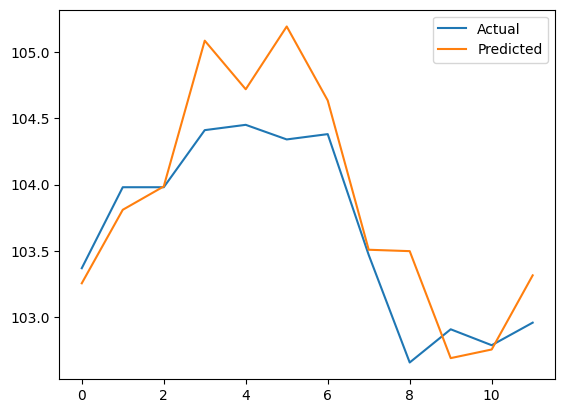

In [79]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, median_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
from tensorflow.keras.optimizers import Adam

class GRUForecaster:
    def __init__(self, data_path, target_col, lags=list(range(1,13)), timesteps=3):
        self.data_path = data_path
        self.target_col = target_col
        self.lags = lags
        self.timesteps = timesteps
        self.df = None
        self.scaler = StandardScaler()

    def load_data(self):
        self.df = pd.read_csv(self.data_path, parse_dates=['time'], index_col='time')
        self.df[self.target_col] = self.scaler.fit_transform(self.df[[self.target_col]])
        for lag in self.lags:
            self.df[f'lag_{lag}'] = self.df[self.target_col].shift(lag)
        self.df = self.df.dropna()

    def prepare_data(self, test_size=12):
        features = self.df[[f'lag_{lag}' for lag in self.lags]].values
        target = self.df[self.target_col].values
        X, y = [], []
        for i in range(len(features) - self.timesteps):
            X.append(features[i:i + self.timesteps])
            y.append(target[i + self.timesteps])
        X, y = np.array(X), np.array(y)
        return X[:-test_size], X[-test_size:], y[:-test_size], y[-test_size:]

    def build_model(self, input_shape):
        model = Sequential([
            GRU(64, input_shape=input_shape),
            Dense(1)
        ])
        model.compile(optimizer=Adam(learning_rate=0.01), loss='mse')
        return model


    def run(self, test_size=12):
        self.load_data()
        X_train, X_test, y_train, y_test = self.prepare_data(test_size)
        model = self.build_model((X_train.shape[1], X_train.shape[2]))
        model.fit(X_train, y_train, epochs=50, batch_size=16, verbose=0)
        predictions = model.predict(X_test).flatten()
        predictions = self.scaler.inverse_transform(predictions.reshape(-1, 1)).flatten()
        y_test = self.scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
        mse = mean_squared_error(y_test, predictions)
        rmse = np.sqrt(mean_squared_error(y_test, predictions))
        mae = median_absolute_error(y_test, predictions)
        mape = mean_absolute_percentage_error(y_test, predictions) * 100
        print(f"RMSE: {rmse:.4f}, MSE: {mse:.4f}, MAE: {mae:.4f}, MAPE: {mape:.2f}%")
        plt.plot(y_test, label='Actual')
        plt.plot(predictions, label='Predicted')
        plt.legend()
        plt.show()

# Sử dụng
forecaster = GRUForecaster(data_path="data/analyzed_time_series.csv", target_col='cpi_yoy')
forecaster.run()

1/1 [==============================] - 1s 614ms/step
RMSE: 0.4852, MSE: 0.2354, MAE: 0.3868, MAPE: 0.40%


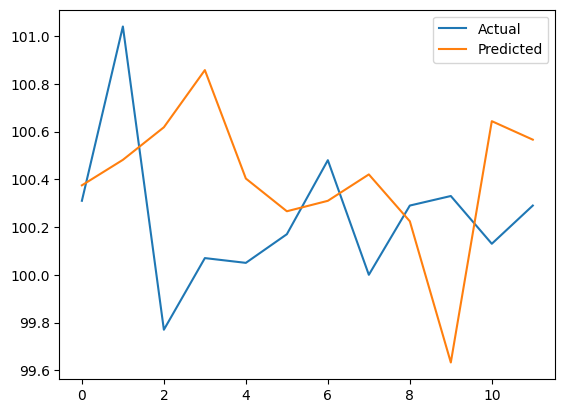

In [80]:
forecaster = GRUForecaster(data_path="data/analyzed_time_series.csv", target_col='cpi_mom')
forecaster.run()

1/1 [==============================] - 0s 159ms/step
RMSE: 0.4429, MSE: 0.1962, MAE: 0.3240, MAPE: 0.35%


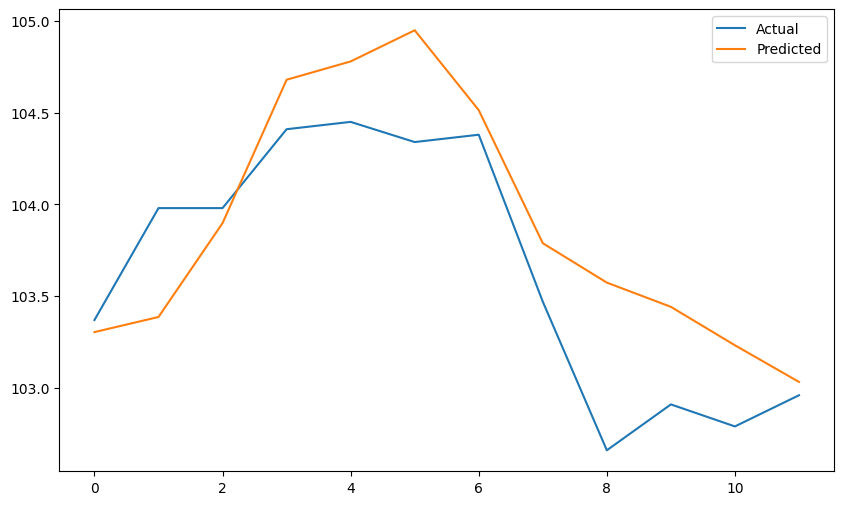

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, median_absolute_error
from tensorflow.keras.layers import Input, Dense, LayerNormalization, MultiHeadAttention
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

class TransformerForecaster:
    def __init__(self, data_path, target_col, lags=list(range(1,13)), timesteps=3):
        self.data_path = data_path
        self.target_col = target_col
        self.lags = lags
        self.timesteps = timesteps
        self.df = None
        self.scaler = StandardScaler()

    def load_data(self):
        try:
            self.df = pd.read_csv(self.data_path, parse_dates=['time'], index_col='time')
            self.df[self.target_col] = self.scaler.fit_transform(self.df[[self.target_col]])
            for lag in self.lags:
                self.df[f'lag_{lag}'] = self.df[self.target_col].shift(lag)
            self.df = self.df.dropna()
        except FileNotFoundError:
            print(f"Error: File {self.data_path} not found")
            raise
        except KeyError:
            print(f"Error: Column 'time' or '{self.target_col}' not found in the data")
            raise

    def prepare_data(self, test_size=12):
        features = self.df[[f'lag_{lag}' for lag in self.lags]].values
        target = self.df[self.target_col].values
        X, y = [], []
        for i in range(len(features) - self.timesteps):
            X.append(features[i:i + self.timesteps])
            y.append(target[i + self.timesteps])
        X, y = np.array(X), np.array(y)
        return X[:-test_size], X[-test_size:], y[:-test_size], y[-test_size:]

    def build_model(self, input_shape, num_heads=4, key_dim=64):
        inputs = Input(shape=input_shape)
        x = MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)(inputs, inputs)
        x = LayerNormalization(epsilon=1e-6)(x)
        x = Dense(64, activation='relu')(x)
        x = Dense(1)(x[:, -1, :])  # Take the last timestep
        model = Model(inputs=inputs, outputs=x)
        model.compile(optimizer=Adam(0.001), loss='mse')
        return model

    def run(self, test_size=12):
        self.load_data()
        X_train, X_test, y_train, y_test = self.prepare_data(test_size)
        model = self.build_model((X_train.shape[1], X_train.shape[2]))
        model.fit(X_train, y_train, epochs=50, batch_size=16, verbose=0)
        predictions = model.predict(X_test).flatten()
        predictions = self.scaler.inverse_transform(predictions.reshape(-1, 1)).flatten()
        y_test = self.scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
        mse = mean_squared_error(y_test, predictions)
        rmse = np.sqrt(mse)
        mae = median_absolute_error(y_test, predictions)
        mape = mean_absolute_percentage_error(y_test, predictions) * 100
        print(f"RMSE: {rmse:.4f}, MSE: {mse:.4f}, MAE: {mae:.4f}, MAPE: {mape:.2f}%")
        plt.figure(figsize=(10, 6))
        plt.plot(y_test, label='Actual')
        plt.plot(predictions, label='Predicted')
        plt.legend()
        plt.show()


forecaster = TransformerForecaster(data_path="data/analyzed_time_series.csv", target_col='cpi_yoy')
forecaster.run()


1/1 [==============================] - 0s 171ms/step
RMSE: 0.4016, MSE: 0.1613, MAE: 0.2219, MAPE: 0.32%


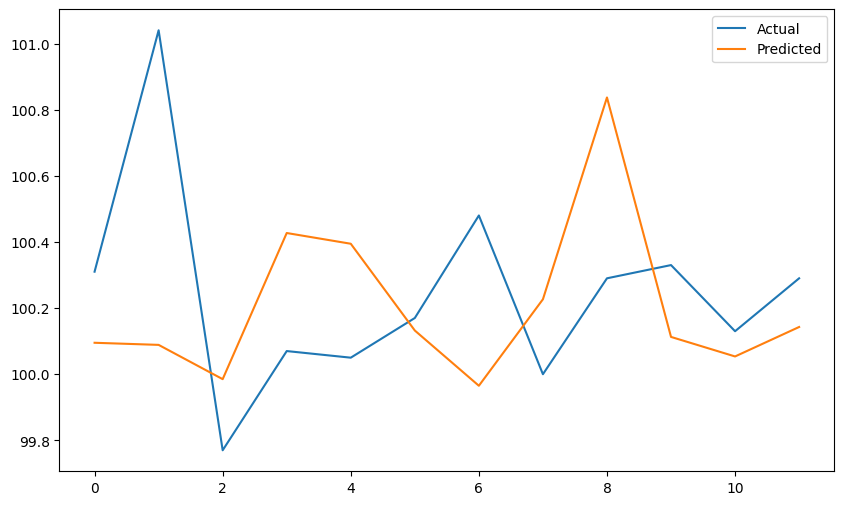

In [5]:
forecaster = TransformerForecaster(data_path="data/analyzed_time_series.csv", target_col='cpi_mom')
forecaster.run()


RMSE: 0.7961, MSE: 0.6337, MAE: 0.5168, MAPE: 0.65%


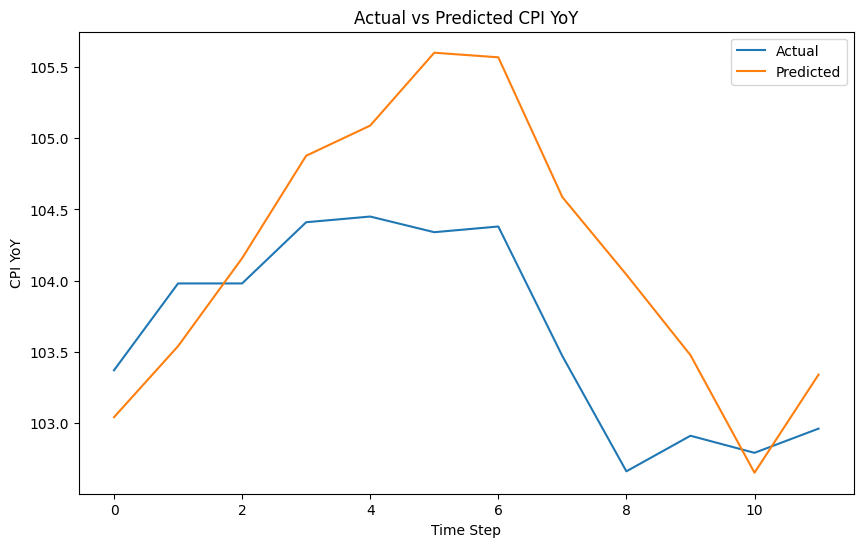

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, median_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam

class MLPForecaster:
    def __init__(self, data_path, target_col, lags=list(range(1,13)), timesteps=3):
        self.data_path = data_path
        self.target_col = target_col
        self.lags = lags
        self.timesteps = timesteps
        self.df = None
        self.scaler = StandardScaler()

    def load_data(self):
        try:
            self.df = pd.read_csv(self.data_path, parse_dates=['time'], index_col='time')
            self.df[self.target_col] = self.scaler.fit_transform(self.df[[self.target_col]])
            for lag in self.lags:
                self.df[f'lag_{lag}'] = self.df[self.target_col].shift(lag)
            self.df = self.df.dropna()
        except FileNotFoundError:
            print(f"Error: File {self.data_path} not found")
            raise
        except KeyError:
            print(f"Error: Column 'time' or '{self.target_col}' not found in the data")
            raise

    def prepare_data(self, test_size=12):
        features = self.df[[f'lag_{lag}' for lag in self.lags]].values
        target = self.df[self.target_col].values
        X, y = [], []
        for i in range(len(features) - self.timesteps):
            X.append(features[i:i + self.timesteps])
            y.append(target[i + self.timesteps])
        X, y = np.array(X), np.array(y)
        return X[:-test_size], X[-test_size:], y[:-test_size], y[-test_size:]

    def build_model(self, input_shape):
        model = Sequential([
            Flatten(input_shape=input_shape),
            Dense(64, activation='relu'),
            Dense(1)
        ])
        model.compile(optimizer=Adam(0.001), loss='mse')
        return model

    def run(self, test_size=12):
        self.load_data()
        X_train, X_test, y_train, y_test = self.prepare_data(test_size)
        model = self.build_model((X_train.shape[1], X_train.shape[2]))
        model.fit(X_train, y_train, epochs=50, batch_size=16, verbose=0)
        predictions = model.predict(X_test, verbose=0).flatten()
        predictions = self.scaler.inverse_transform(predictions.reshape(-1, 1)).flatten()
        y_test = self.scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
        mse = mean_squared_error(y_test, predictions)
        rmse = np.sqrt(mse)
        mae = median_absolute_error(y_test, predictions)
        mape = mean_absolute_percentage_error(y_test, predictions) * 100
        print(f"RMSE: {rmse:.4f}, MSE: {mse:.4f}, MAE: {mae:.4f}, MAPE: {mape:.2f}%")
        plt.figure(figsize=(10, 6))
        plt.plot(y_test, label='Actual')
        plt.plot(predictions, label='Predicted')
        plt.title('Actual vs Predicted CPI YoY')
        plt.xlabel('Time Step')
        plt.ylabel('CPI YoY')
        plt.legend()
        plt.show()


forecaster = MLPForecaster(data_path="data/analyzed_time_series.csv", target_col='cpi_yoy')
forecaster.run()

RMSE: 0.3767, MSE: 0.1419, MAE: 0.2865, MAPE: 0.30%


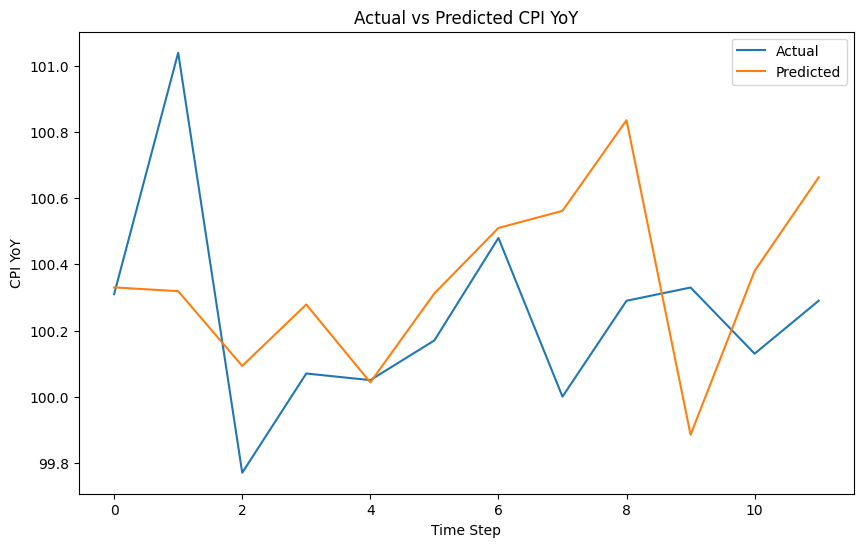

In [6]:
forecaster = MLPForecaster(data_path="data/analyzed_time_series.csv", target_col='cpi_mom')
forecaster.run()

RMSE: 0.4480, MSE: 0.2007, MAE: 0.3014, MAPE: 0.34%


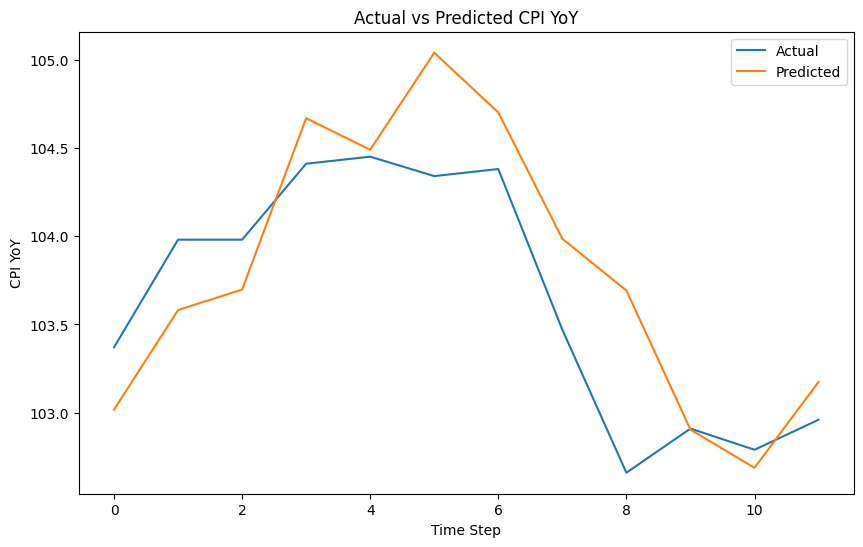

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, median_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import TimeDistributed, Conv1D, LSTM, Dense, Flatten
from tensorflow.keras.optimizers import Adam

class CNNLSTMForecaster:
    def __init__(self, data_path, target_col, lags=list(range(1,13)), timesteps=3):
        self.data_path = data_path
        self.target_col = target_col
        self.lags = lags
        self.timesteps = timesteps
        self.df = None
        self.scaler = StandardScaler()

    def load_data(self):
        try:
            self.df = pd.read_csv(self.data_path, parse_dates=['time'], index_col='time')
            self.df[self.target_col] = self.scaler.fit_transform(self.df[[self.target_col]])
            for lag in self.lags:
                self.df[f'lag_{lag}'] = self.df[self.target_col].shift(lag)
            self.df = self.df.dropna()
        except FileNotFoundError:
            print(f"Error: File {self.data_path} not found")
            raise
        except KeyError:
            print(f"Error: Column 'time' or '{self.target_col}' not found in the data")
            raise

    def prepare_data(self, test_size=12):
        features = self.df[[f'lag_{lag}' for lag in self.lags]].values
        target = self.df[self.target_col].values
        X, y = [], []
        for i in range(len(features) - self.timesteps):
            X.append(features[i:i + self.timesteps])
            y.append(target[i + self.timesteps])
        X, y = np.array(X), np.array(y)
        # Reshape X to (samples, timesteps, features, 1) for Conv1D
        X = X.reshape(X.shape[0], X.shape[1], X.shape[2], 1)
        return X[:-test_size], X[-test_size:], y[:-test_size], y[-test_size:]

    def build_model(self, input_shape):
        model = Sequential([
            # Input shape: (timesteps, features, channels)
            TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu'), 
                           input_shape=(input_shape[1], input_shape[2], 1)),
            TimeDistributed(Flatten()),
            LSTM(50, activation='relu'),
            Dense(1)
        ])
        model.compile(optimizer=Adam(0.001), loss='mse')
        return model

    def run(self, test_size=12):
        self.load_data()
        X_train, X_test, y_train, y_test = self.prepare_data(test_size)
        model = self.build_model(X_train.shape)
        model.fit(X_train, y_train, epochs=50, batch_size=16, verbose=0)
        predictions = model.predict(X_test, verbose=0).flatten()
        predictions = self.scaler.inverse_transform(predictions.reshape(-1, 1)).flatten()
        y_test = self.scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
        mse = mean_squared_error(y_test, predictions)
        rmse = np.sqrt(mse)
        mae = median_absolute_error(y_test, predictions)
        mape = mean_absolute_percentage_error(y_test, predictions) * 100
        print(f"RMSE: {rmse:.4f}, MSE: {mse:.4f}, MAE: {mae:.4f}, MAPE: {mape:.2f}%")
        plt.figure(figsize=(10, 6))
        plt.plot(y_test, label='Actual')
        plt.plot(predictions, label='Predicted')
        plt.title('Actual vs Predicted CPI YoY')
        plt.xlabel('Time Step')
        plt.ylabel('CPI YoY')
        plt.legend()
        plt.show()

# Usage
if __name__ == "__main__":
    forecaster = CNNLSTMForecaster(data_path="data/analyzed_time_series.csv", target_col='cpi_yoy')
    forecaster.run()

In [ ]:
forecaster = CNNLSTMForecaster(data_path="data/analyzed_time_series.csv", target_col='cpi_mom')
forecaster.run()